# Assignment 2: recommender System

## Code from the lecture

In [1]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [2]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [3]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [4]:
%%time
#again, implementation not efficient: better use lamda opperators 
D=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D[i,j]=CosineDist(R[:,i],R[:,j])

Wall time: 1min 5s


In [5]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title),D))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [6]:
# Euclidian distance function between two points
def EucliDist(a,b):
    return np.linalg.norm(a-b)

In [7]:
%%time

d=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            d[i,j]=EucliDist(R[:,i],R[:,j])

Wall time: 39.9 s


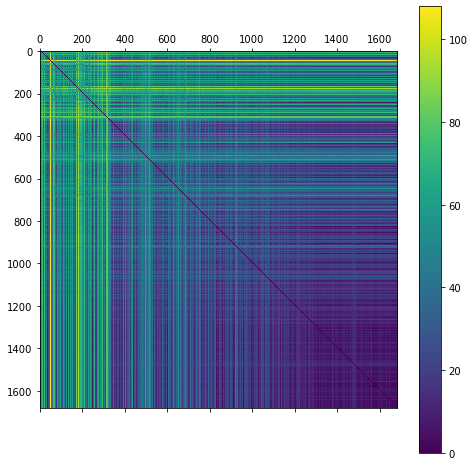

In [8]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(np.absolute(d))
plt.colorbar()

In [9]:
print(type(d))
print(d.shape)
print(d.dtype)
print(d.itemsize)
print(d.nbytes)
print(d.data)
print(d.ndim)

<class 'numpy.ndarray'>
(1682, 1682)
float64
8
22632992
2


2.3701802757158004

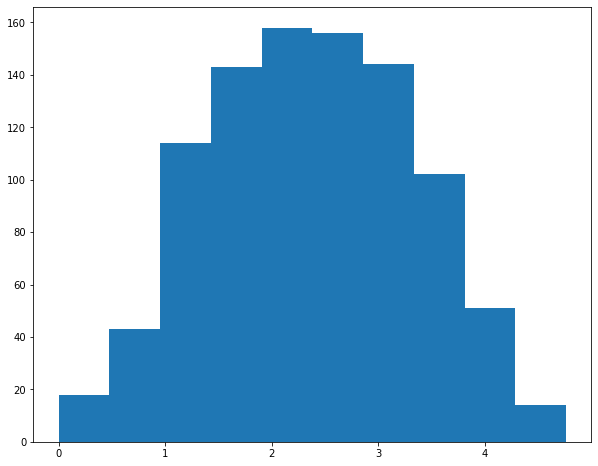

In [10]:
my_score=test_Score(D,R)
plt.hist(my_score)
np.mean(my_score)

1.4630328738069989

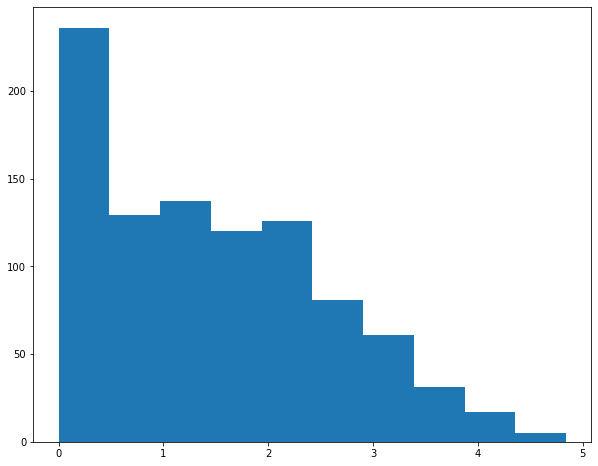

In [11]:
my_score=test_Score(d,R)
plt.hist(my_score)
np.mean(my_score)

In [12]:
# Recommandation done with original distance array
CII("Star Wars",D)

recommending movies for: 'Star Wars (1977)'


180          Return of the Jedi (1983)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
0                     Toy Story (1995)
126              Godfather, The (1972)
Name: title, dtype: object

In [13]:
# Recommandation done with new distance array
CII("Star Wars",d)

recommending movies for: 'Star Wars (1977)'


989              Anna Karenina (1997)
1061    Four Days in September (1997)
1126          Truman Show, The (1998)
937        Smile Like Yours, A (1997)
1242               Night Flier (1997)
Name: title, dtype: object

## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

In [14]:
random_IDs=np.random.choice(movies.movie_id,5) #Randomly choose 5 ID within the the movie ID list
movies_rand=getNameByID(random_IDs) #Get movies names by their IDs
print('Movies randomly recommanded:')
print(movies_rand)

Movies randomly recommanded:
1170                                    Wild Reeds (1994)
1334                              American Buffalo (1996)
1109                                     Tank Girl (1995)
381     Adventures of Priscilla, Queen of the Desert, ...
1481                   Gate of Heavenly Peace, The (1995)
Name: title, dtype: object


In [15]:
movies_ratings=np.nanmean(R, axis=0)
max_IDs = (-movies_ratings).argsort()[:5] #Get IDs of the 5 top rated movies over all users first
movies_max=getNameByID(max_IDs) #Get movies names by their IDs
print('Top movies over all users:')
print(movies_max)

Top movies over all users:
49                   Star Wars (1977)
99                       Fargo (1996)
180         Return of the Jedi (1983)
257                    Contact (1997)
173    Raiders of the Lost Ark (1981)
Name: title, dtype: object


## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$


In [16]:
# Singular value decomposition implementation

left_sv, nzero_sv, right_sv = np.linalg.svd(D)
print(left_sv.shape)
print(nzero_sv.shape)
print(right_sv.shape)

(1682, 1682)
(1682,)
(1682, 1682)


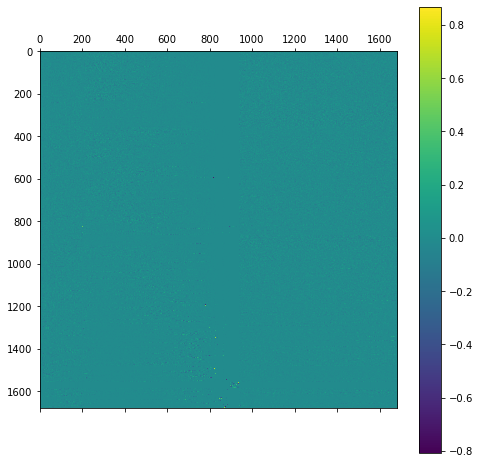

In [17]:
# Left singular value plot
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(left_sv)
plt.colorbar() 

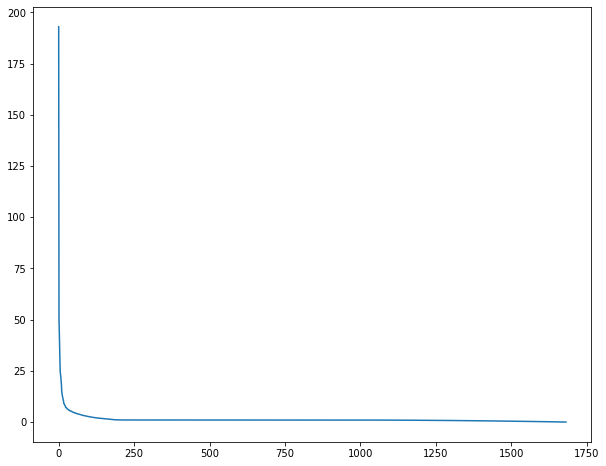

In [18]:
# Non zero singular value plot
plt.plot(nzero_sv);

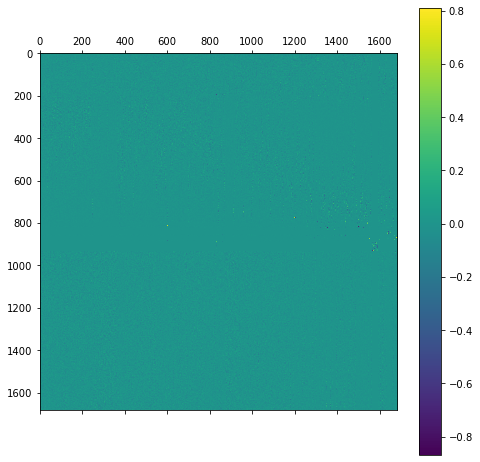

In [19]:
# Right singular value plot
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(right_sv)
plt.colorbar() 

In [20]:
def Reconstitute(U,D,V,k):
    return np.matrix(U[:, :k]) * np.diag(D[:k]) * np.matrix(V[:k, :])

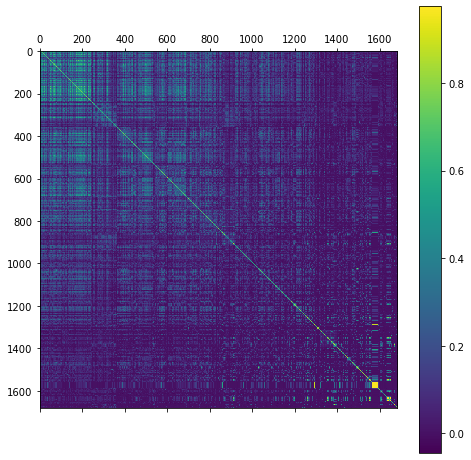

In [21]:
# Here we reconstructe our rating matrix using SVD reconstructe function
# We take an arbitrary singular value of 200
# The objective here is to choose between rapidity or precision. The more singular values we have the more precise the reconstruction is
# The less singular values we have the more rapide the reconstruction is

reconst_D=Reconstitute(left_sv,nzero_sv,right_sv, 200)

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(reconst_D)
plt.colorbar()

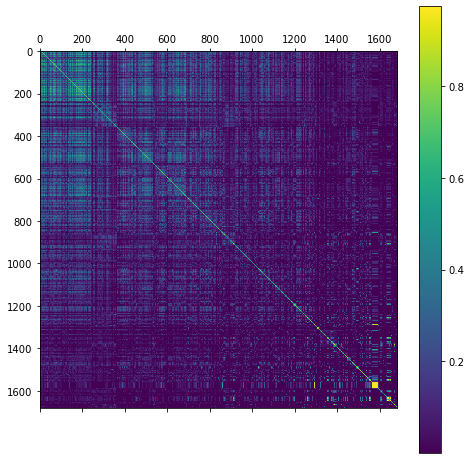

In [22]:
#There is some negative values that create error with test_Score function
#So we take their absolute in order to resolve the error

absolute_mx=np.where(reconst_D<0,np.abs(reconst_D),reconst_D)

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(absolute_mx)
plt.colorbar()


[0. 0. 0. ... 0. 0. 0.]


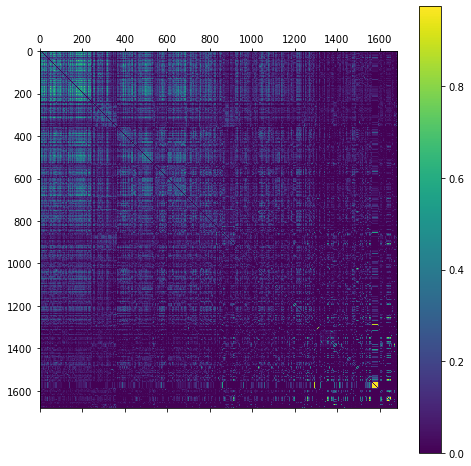

In [23]:
#We know that a film should have a distance to himself of 0 but the reconstruction give an average distance of 0.7
#So we set the diagonal of the reconstructed matrix to 0 in order to avoid recommending the film to after watching it

np.fill_diagonal(absolute_mx, 0)

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.matshow(absolute_mx)
plt.colorbar()

diag=np.diag(absolute_mx)
print(diag)

2.383372216330859

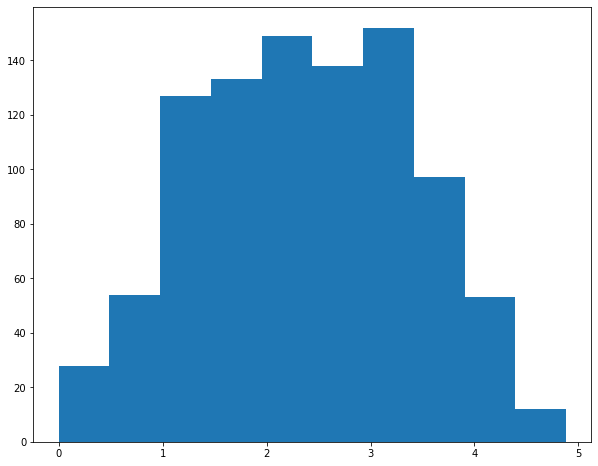

In [24]:
my_score=test_Score(absolute_mx,R)
plt.hist(my_score)
np.mean(my_score)

In [25]:
CII("Star Wars",absolute_mx)

recommending movies for: 'Star Wars (1977)'


180          Return of the Jedi (1983)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
0                     Toy Story (1995)
120      Independence Day (ID4) (1996)
Name: title, dtype: object